# HT 2 : Feature engineering
---
В файлах приложен датасет - лог рекламных событий за один временной период ('dataset_ht1.csv'). Для этого датасета необходимо выполнить задания по **feature engineering**. Проверка задания будет осуществляться на датасете из этого же лога, но за другой временной период.


### 🔧 Подготовка среды

In [1]:
# ! pip3 install pandas matplotlib

### 1️⃣ Импорт библиотек и загрузка датасета

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset_ht1.csv')

In [3]:
df.head(2)

,Unnamed: 0,ip_hash,uniqid_hash,logid_hash,orderid_hash,countertype,blocktype,browsername,eventcost,detaileddevicetype,referer,pagetype,tagid_hash,eventtime,target,useragent,pageid_hash
0,1,76XjK3hFY0zNxVSsKbpU-z5jtDxDI3Y29zro49jeOaQ,Y15Ge7TaSNgLVK9tz3RxkSz-KIGYn4gm1t4r3j5XEaA,sMptv93jNdf7uuyYfkJRxIYz2omrHhcKoMtSdEP0Vt4,MHgmUR5y_qSB5RK70nhLKv9w_2NX2DrqcIchw3Mrr3Q,1,banner,YandexBrowser,0,Windows,https://yandex.ru/games/app/334366,context,lLHXxdxU3gTJWtnluPzTjCrfUliCQabPGv_67f8_fe8,1748725200,False,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,CDFXqwDRdTZkXxePSHwWPHlTZ0c54YYu1Z-HXDsiqXo
1,2,_d5C-zr63nB_-VCdpXOHpu-e3w-5K_13_VHKFnIatn8,rcYeyMMqpsXH9ZD7PGeV719Fp_xzMEHjYGgcD4islxw,UkUs5D4YbgHE65lI1A_XGwP1Z24PdtspdalVewL5rXs,A2IDLxIg7gZxem__iysv2-X6HfT5bPVuR9nNxmtPgTk,1,banner,YandexBrowser,0,Android,https://dzen.ru/a/XHKGN0Zi9wDMxXsB,context,jLEI3rlgrXd6NlaRHArrMegkdislwxd9FGPKcfdf6Ro,1748725201,False,Mozilla/5.0 (Linux; arm_64; Android 14; RMX393...,tBJ25sKPdALeIM_gy1U0FyUNOAWc6aR3x29rtuueYcM


#### Описание датасета

`ip_hash` - ip адрес\
`uniqid_hash` - id пользователя\
`logid_hash` - id события\
`orderid_hash` - id рекламной кампании\
`countertype` - тип события (1 - показ, 2 - клик)\
`blocktype` - тип рекламного блока\
`browsername` - браузер\
`eventcost` - стоимость рекламного события \
`detaileddevicetype` - устройство пользователя\
`referer` - реферер-ссылка, с которой пользователь перешел\
`pagetype` - тип сайта\
`tagid_hash` - id партнера\
`eventtime` - время события\
`target` - целевая переменная \
`useragent` - юзерагент\
`pageid_hash` - id сайта

In [4]:
df.target.value_counts()

target
False    98725
True      1275
Name: count, dtype: int64

In [5]:
df.target.value_counts(normalize=True)

target
False    0.98725
True     0.01275
Name: proportion, dtype: float64

In [6]:
df.shape

(100000, 17)

### 2️⃣ Задание 0

Реализовать признаки: 

- количество кликов пользователя (`uniqid`) за последний час
- количество событий с ip адреса за последние сутки
- доля top-1 ip адреса на сайте (`pageid`) за последние сутки


In [7]:
df['eventtime_dt'] = pd.to_datetime(df['eventtime'], unit='s')
df = df.sort_values('eventtime_dt')
df['countertype_2'] = (df['countertype'] == 2).astype(int)

In [177]:
# 1.
df['event_countertype_2_window_1h'] =  df.groupby('uniqid_hash')[['eventtime_dt', 'countertype_2']].rolling(
    window = '1h',
    on = 'eventtime_dt',
    closed = 'left',
).sum().reset_index(level=0, drop=True)['countertype_2']

In [178]:
df['event_countertype_2_window_1h'].isna().mean()

np.float64(0.99867)

In [179]:
# 2.
df['ip_events_window_1d'] = df.groupby('ip_hash')[['eventtime_dt', 'countertype']].rolling(
    window = '1d',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True)['countertype']

In [180]:
df['ip_events_window_1d'].isna().mean()

np.float64(0.94897)

In [181]:
df['ip_events_window_1d'].median(), df['ip_events_window_1d'].max()

(np.float64(1.0), np.float64(107.0))

In [182]:
# 3.
def get_top1_percentage(x):
    values = x.value_counts(normalize=True, sort=True, ascending=False)
    return values.iloc[0]
    
df['ip_numeric'] = pd.factorize(df['ip_hash'])[0] # workaround to fix Cannot aggregate non-numeric type: object

df['pageid_top1_ip_pr_window_1d'] = (
    df.groupby('pageid_hash')[['eventtime_dt', 'ip_numeric']].rolling(
        window = '1D',
        on = 'eventtime_dt',
        closed = 'left',
    ).agg(lambda x: get_top1_percentage(x))
    .reset_index(level=0, drop=True)['ip_numeric']
)

### 3️⃣ Задание 1 

Сделать 5 осмысленных признаков, которые лучше всего объясняют таргет в совокупности.

Ограничения: Суммарный размер RAM для признаков не более 10 MB

#### 1. Трафик по id рекламной компании

Создадим пару признаков на основе трафика внутри рекламной кампании.

Построим графики и отберём признаки, которые лучше всего разделяют классы таргета (0 и 1).

Итоговые признаки: `orderid_events_window_3h`, `orderid_2h_div_1h`

In [164]:
df['orderid_events_window_1h'] = df.groupby('orderid_hash')[['eventtime_dt', 'countertype']].rolling(
    window = '1h',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True)['countertype']

df['orderid_events_window_2h'] = df.groupby('orderid_hash')[['eventtime_dt', 'countertype']].rolling(
    window = '2h',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True)['countertype']


df['orderid_events_window_3h'] = df.groupby('orderid_hash')[['eventtime_dt', 'countertype']].rolling(
    window = '3h',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True)['countertype'] # TO ADD

df['orderid_events_window_6h'] = df.groupby('orderid_hash')[['eventtime_dt', 'countertype']].rolling(
    window = '6h',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True)['countertype']

df['orderid_events_window_9h'] = df.groupby('orderid_hash')[['eventtime_dt', 'countertype']].rolling(
    window = '9h',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True).sort_index()['countertype']


df['orderid_events_2h_delta_1h'] =  (df['orderid_events_window_2h'] - df['orderid_events_window_1h'])
df['orderid_events_3h_delta_1h'] =  (df['orderid_events_window_3h'] - df['orderid_events_window_2h'])

df['orderid_2h_div_1h'] = df['orderid_events_2h_delta_1h']  / (df['orderid_events_window_1h'] + 1) # TO ADD
df['orderid_3h_div_1h'] = df['orderid_events_3h_delta_1h']  / (df['orderid_events_2h_delta_1h'] + 1)

#### Сравнение

In [165]:
print(f"Is na: {df[df['target'] == 1]['orderid_2h_div_1h'].isna().mean():.2f} {df[df['target'] == 0]['orderid_2h_div_1h'].isna().mean():.2f}")
print(f"Median: {df[df['target'] == 1]['orderid_2h_div_1h'].median():.2f} {df[df['target'] == 0]['orderid_2h_div_1h'].median():.2f}")

Is na: 0.55 0.64
Median: 0.71 0.50


In [166]:
print(df[df['target'] == 1]['orderid_3h_div_1h'].median(), df[df['target'] == 0]['orderid_3h_div_1h'].median())

0.7142857142857143 0.42857142857142855


In [167]:
df[df['target'] == 1]['orderid_events_window_3h'].median(), df[df['target'] == 0]['orderid_events_window_3h'].median()

(np.float64(11.0), np.float64(4.0))

In [168]:
df[df['target'] == 1]['orderid_events_window_6h'].median(), df[df['target'] == 0]['orderid_events_window_6h'].median()

(np.float64(15.0), np.float64(4.0))

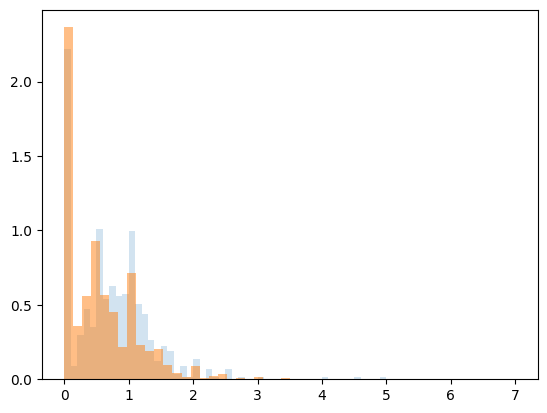

In [169]:
plt.hist(df[df['target'] == 1]['orderid_2h_div_1h'], alpha=0.2, density=1, bins=50)
plt.hist(df[df['target'] == 0]['orderid_2h_div_1h'], alpha=0.5, density=1, bins=50);

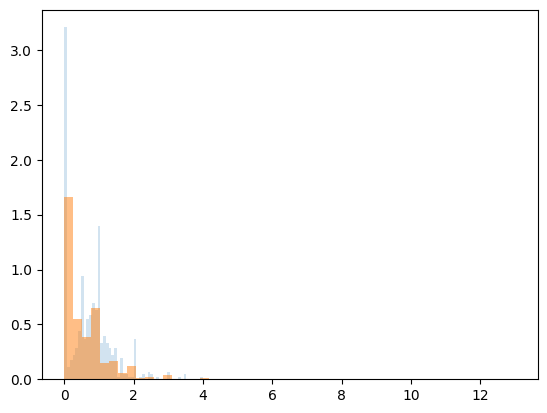

In [170]:
plt.hist(df[df['target'] == 1]['orderid_3h_div_1h'], alpha=0.2, density=1, bins=50)
plt.hist(df[df['target'] == 0]['orderid_3h_div_1h'], alpha=0.5, density=1, bins=50);

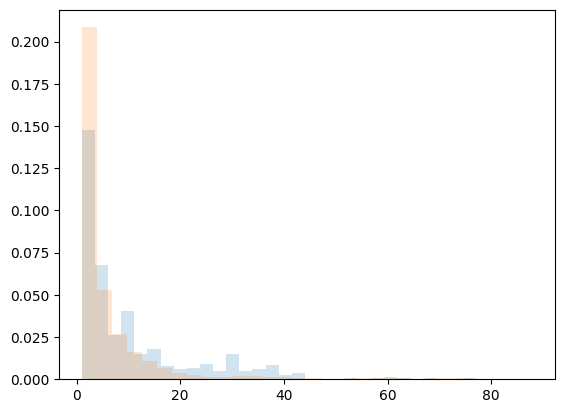

In [171]:
plt.hist(df[df['target'] == 1]['orderid_events_window_1h'], alpha=0.2, density=True, bins=30)
plt.hist(df[df['target'] == 0]['orderid_events_window_1h'], alpha=0.2, density=True, bins=30);

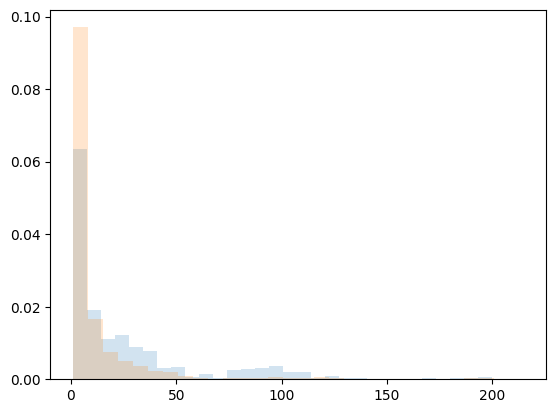

In [172]:
plt.hist(df[df['target'] == 1]['orderid_events_window_3h'], alpha=0.2, density=True, bins=30)
plt.hist(df[df['target'] == 0]['orderid_events_window_3h'], alpha=0.2, density=True, bins=30);

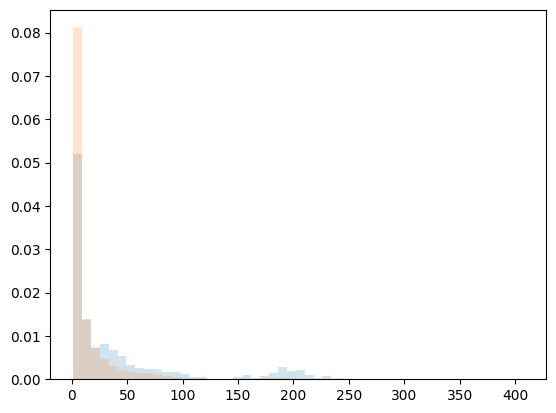

In [173]:
plt.hist(df[df['target'] == 1]['orderid_events_window_6h'], alpha=0.2, density=True, bins=50)
plt.hist(df[df['target'] == 0]['orderid_events_window_6h'], alpha=0.2, density=True, bins=50);

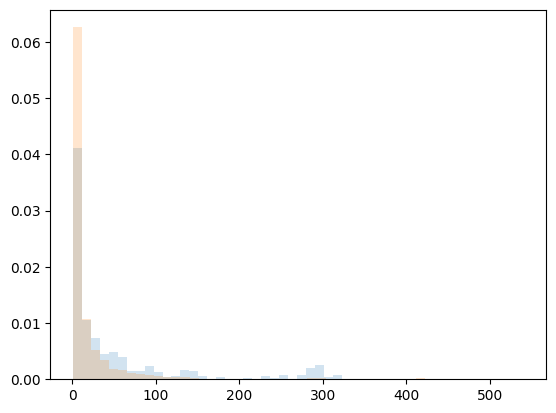

In [174]:
plt.hist(df[df['target'] == 1]['orderid_events_window_9h'], alpha=0.2, density=True, bins=50)
plt.hist(df[df['target'] == 0]['orderid_events_window_9h'], alpha=0.2, density=True, bins=50);

#### 2. Трафик по партнеру (tagid_hash)

Итоговые признаки: `tagid_events_window_1h`, `tagid_events_window_div_1h_9h`

In [237]:
col = 'tagid_hash'
df[f'tagid_events_window_1h'] = df.groupby(col)[['eventtime_dt', 'countertype']].rolling(
    window = '1h',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True)['countertype']

df[f'tagid_events_window_3h'] = df.groupby(col)[['eventtime_dt', 'countertype']].rolling(
    window = '3h',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True)['countertype']

df[f'tagid_events_window_6h'] = df.groupby(col)[['eventtime_dt', 'countertype']].rolling(
    window = '6h',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True)['countertype']

df[f'tagid_events_window_9h'] = df.groupby(col)[['eventtime_dt', 'countertype']].rolling(
    window = '9h',
    on = 'eventtime_dt',
    closed = 'left',
).count().reset_index(level=0, drop=True)['countertype']

df['tagid_events_window_div_1h_9h'] = ((df['tagid_events_window_1h'] )/ df['tagid_events_window_9h'])


#### Графики

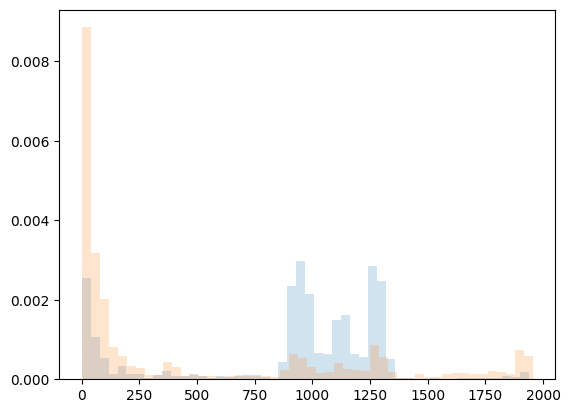

In [188]:
plt.hist(df[df['target'] == 1]['tagid_events_window_1h'], alpha=0.2, density=True, bins=50)
plt.hist(df[df['target'] == 0]['tagid_events_window_1h'], alpha=0.2, density=True, bins=50);

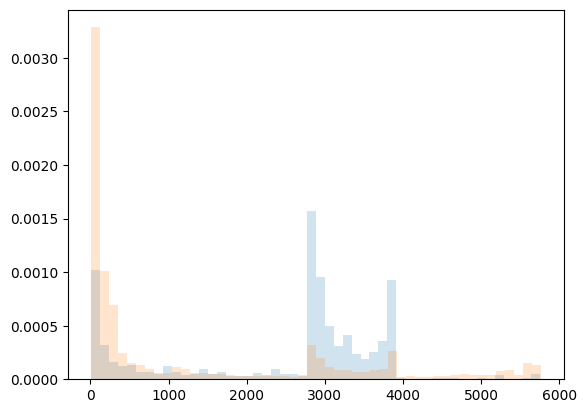

In [189]:
plt.hist(df[df['target'] == 1]['tagid_events_window_3h'], alpha=0.2, density=True, bins=50)
plt.hist(df[df['target'] == 0]['tagid_events_window_3h'], alpha=0.2, density=True, bins=50);

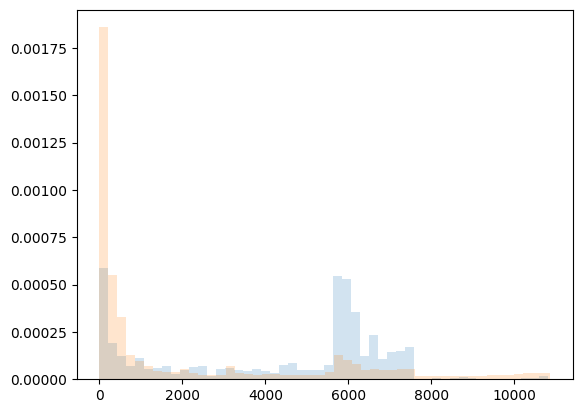

In [190]:
plt.hist(df[df['target'] == 1]['tagid_events_window_6h'], alpha=0.2, density=True, bins=50)
plt.hist(df[df['target'] == 0]['tagid_events_window_6h'], alpha=0.2, density=True, bins=50);

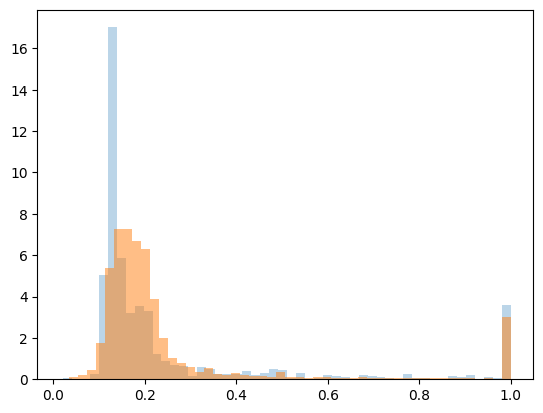

In [238]:
plt.hist(df[df['target'] == 1]['tagid_events_window_div_1h_9h'], alpha=0.3, density=True, bins=50)
plt.hist(df[df['target'] == 0]['tagid_events_window_div_1h_9h'], alpha=0.5, density=True, bins=50);

#### 3. Топ 1  реклама/партнер по событиям на сайте

Итоговые признаки: ``pageid_top1_orderid_pr_window_1d``, ``pageid_top1_targid_pr_window_1d``

In [204]:
def get_top1_percentage(x):
    values = x.value_counts(normalize=True, sort=True, ascending=False)
    return values.iloc[0] if values.shape[0] > 5 else 0

def get_top1(x):
    values = x.value_counts(normalize=True, sort=True, ascending=False)
    return values.index[0]


window = '6h'
    
df['orderid_numeric'] = pd.factorize(df['orderid_hash'])[0] # workaround to fix Cannot aggregate non-numeric type: object

df[f'pageid_top1_orderid_pr_window_{window}'] = (
    df.groupby('pageid_hash')[['eventtime_dt', 'orderid_numeric']].rolling(
        window = window,
        on = 'eventtime_dt',
        closed = 'left',
    ).agg(lambda x: get_top1_percentage(x))
    .reset_index(level=0, drop=True)['orderid_numeric']
)

 
# df['pageid_top1_orderid_window_6h'] = (
#     df.groupby('pageid_hash')[['eventtime_dt', 'orderid_numeric']].rolling(
#         window = '6h',
#         on = 'eventtime_dt',
#         closed = 'left',
#     ).agg(lambda x: get_top1_percentage(x))
#     .reset_index(level=0, drop=True)['orderid_numeric']
# ) # TO ADD 
# df['is_top_page_orderid'] = (df['orderid_numeric' ] == df['pageid_top1_orderid_window_1d'])

df['tagid_numeric'] = pd.factorize(df['tagid_hash'])[0] # workaround to fix Cannot aggregate non-numeric type: object

df[f'pageid_top1_targid_pr_window_{window}'] = (
    df.groupby('pageid_hash')[['eventtime_dt', 'tagid_numeric']].rolling(
        window = window,
        on = 'eventtime_dt',
        closed = 'left',
    ).agg(lambda x: get_top1_percentage(x))
    .reset_index(level=0, drop=True)['tagid_numeric']
) # TO ADD


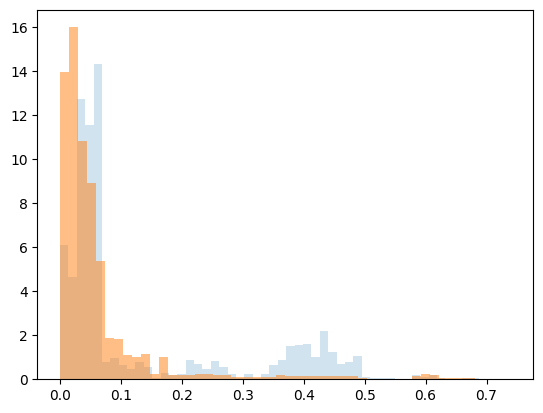

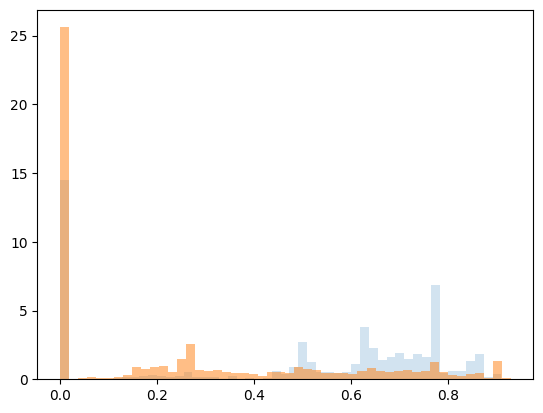

In [205]:
plt.hist(df[df['target'] == 1][f'pageid_top1_orderid_pr_window_{window}'], alpha=0.2, density=1, bins=50)
plt.hist(df[df['target'] == 0][f'pageid_top1_orderid_pr_window_{window}'], alpha=0.5, density=1, bins=50);
plt.show()

plt.hist(df[df['target'] == 1][f'pageid_top1_targid_pr_window_{window}'], alpha=0.2, density=1, bins=50)
plt.hist(df[df['target'] == 0][f'pageid_top1_targid_pr_window_{window}'], alpha=0.5, density=1, bins=50);

#### 4. Разница std временных интервалов между событиями одной рекламы с окном 1h vs с окном 2h

Итоговые признаки: `order_std_1h_div_2h`

In [194]:
def func(x):
    d = (x[1:].values - x[:-1].values) / 3600
    return np.std(d) # (np.percentile(d, 20) - np.percentile(d, 5)) / np.percentile(d, 20)

df['order_std_1h'] = df.groupby('orderid_hash').rolling(
    window = '1h',
    on = 'eventtime_dt',
    closed = 'left',
    min_periods=5,
)['eventtime'].apply(func).reset_index(level=[0,1], drop=True)

df['order_std_3h'] = df.groupby('orderid_hash').rolling(
    window = '2h',
    on = 'eventtime_dt',
    closed = 'left',
    min_periods=5,
)['eventtime'].apply(func).reset_index(level=[0,1], drop=True)

In [195]:
df['order_std_1h_div_2h'] = df['order_std_1h'] / df['order_std_3h']

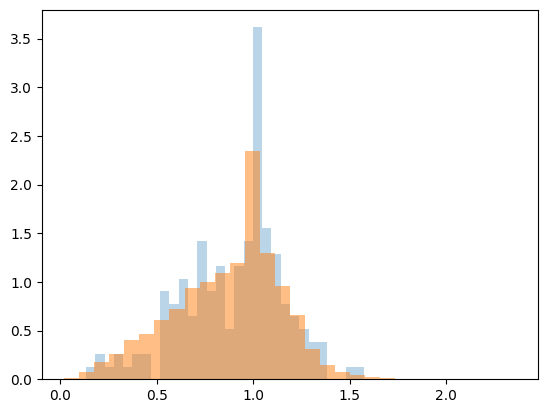

In [196]:
plt.hist(df[df['target'] == 1]['order_std_1h_div_2h'], alpha=0.3, density=True, bins=30)
plt.hist(df[df['target'] == 0]['order_std_1h_div_2h'], alpha=0.5, density=True, bins=30);

In [197]:
df['order_std_1h_div_2h'].isna().sum()

np.int64(88146)

In [200]:
df[df['target'] == 1]['order_std_1h_div_2h'].mean(), df[df['target'] == 0]['order_std_1h_div_2h'].mean()

(np.float64(0.8962115395238742), np.float64(0.8691080183084735))

### Итоговые 7 признаков

In [226]:
features = [
    "orderid_events_window_3h",
    "orderid_2h_div_1h",
    "tagid_events_window_1h",
    "tagid_events_window_div_1h_9h",
    "pageid_top1_orderid_pr_window_6h",
    "pageid_top1_targid_pr_window_6h",
    "order_std_1h_div_2h",
]

In [227]:
total_memory_bytes = df[features].memory_usage(deep=True).sum()
total_memory_mb = total_memory_bytes / (1024 * 1024)

print(f"Total memory usage of DataFrame: {total_memory_mb:.2f} MB")

Total memory usage of DataFrame: 8.12 MB


### 4️⃣ Задание 2 Проверить временное смещение (temporal shift) в полученных признаках.


#### Код

In [228]:
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Tuple

def calculate_psi(
    expected: pd.Series,
    actual: pd.Series,
    buckets: int = 10,
    buckettype: str = 'bins',
    handle_na: bool = False
) -> float:

    def scale_range(input_series, n_bins):
        """Создает бакеты для числовых данных"""
        min_val = input_series.min()
        max_val = input_series.max()
        return np.linspace(min_val, max_val, n_bins + 1)
    
    # Обработка NA значений
    if handle_na:
        # Подсчитываем долю NA в каждой выборке
        expected_na_count = expected.isna().sum()
        actual_na_count = actual.isna().sum()
        
        expected_total = len(expected)
        actual_total = len(actual)
        
        expected_na_percent = expected_na_count / expected_total if expected_total > 0 else 0
        actual_na_percent = actual_na_count / actual_total if actual_total > 0 else 0

    else:
        expected_na_percent = 0
        actual_na_percent = 0

    expected_clean = expected.dropna()
    actual_clean = actual.dropna()

    if len(expected_clean) == 0 or len(actual_clean) == 0:
        if handle_na and (expected_na_percent > 0 or actual_na_percent > 0):
            # Если есть только NA значения, рассчитываем PSI только для NA бина
            expected_na_percent = max(expected_na_percent, 0.0001)
            actual_na_percent = max(actual_na_percent, 0.0001)
            return (actual_na_percent - expected_na_percent) * np.log(actual_na_percent / expected_na_percent)
        else:
            raise ValueError("Недостаточно данных для расчета PSI после удаления NA")
    
    # Определяем границы бакетов на основе expected
    if buckettype == 'bins':
        breakpoints = scale_range(expected_clean, buckets)
    elif buckettype == 'quantiles':
        breakpoints = np.percentile(expected_clean, np.linspace(0, 100, buckets + 1))
    else:
        raise ValueError("buckettype должен быть 'bins' или 'quantiles'")
    
    # Убираем дубликаты границ
    breakpoints = np.unique(breakpoints)
    
    # Создаем бакеты для не-NA значений
    expected_percents = pd.cut(expected_clean, bins=breakpoints, include_lowest=True, duplicates='drop').value_counts(normalize=True).sort_index()
    actual_percents = pd.cut(actual_clean, bins=breakpoints, include_lowest=True, duplicates='drop').value_counts(normalize=True).sort_index()
    
    # Выравниваем индексы
    expected_percents, actual_percents = expected_percents.align(actual_percents, fill_value=0.0001)
    
    # Если обрабатываем NA, добавляем их как отдельный бин
    if handle_na:
        # Корректируем проценты с учетом NA
        expected_percents = expected_percents * (1 - expected_na_percent)
        actual_percents = actual_percents * (1 - actual_na_percent)
        
        # Добавляем NA бин
        expected_percents['NA'] = max(expected_na_percent, 0.0001)
        actual_percents['NA'] = max(actual_na_percent, 0.0001)
    
    # Заменяем нули на малое значение для избежания деления на ноль
    expected_percents = expected_percents.replace(0, 0.0001)
    actual_percents = actual_percents.replace(0, 0.0001)
    
    # Рассчитываем PSI
    psi_value = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
    
    return psi_value


def check_temporal_shift(
    df_base: pd.DataFrame,
    df_current: pd.DataFrame,
    features: List[str],
    buckets: int = 10,
    buckettype: str = 'bins',
    threshold: float = 0.1,
    handle_na: bool = False
) -> Dict[str, Dict[str, Union[float, str]]]:
    results = {}
    
    for feature in features:
        if feature not in df_base.columns:
            results[feature] = {
                'psi': None,
                'status': 'error',
                'interpretation': f'Признак {feature} не найден в базовом датафрейме'
            }
            continue
            
        if feature not in df_current.columns:
            results[feature] = {
                'psi': None,
                'status': 'error',
                'interpretation': f'Признак {feature} не найден в текущем датафрейме'
            }
            continue
        
        try:
            # Рассчитываем PSI
            psi_value = calculate_psi(
                df_base[feature],
                df_current[feature],
                buckets=buckets,
                buckettype=buckettype,
                handle_na=handle_na
            )
            if psi_value < 0.1:
                status = 'stable'
            elif psi_value < 0.2:
                status = 'moderate_shift'
            else:
                status = 'significant_shift'
            
            result_dict = {
                'psi': round(psi_value, 4),
                'status': status,
            }
            
            if handle_na:
                base_na_percent = (df_base[feature].isna().sum() / len(df_base[feature])) * 100
                current_na_percent = (df_current[feature].isna().sum() / len(df_current[feature])) * 100
                result_dict['na_info'] = {
                    'base_na_percent': round(base_na_percent, 2),
                    'current_na_percent': round(current_na_percent, 2),
                    'na_shift': round(current_na_percent - base_na_percent, 2)
                }
            
            results[feature] = result_dict
            
        except Exception as e:
            results[feature] = {
                'psi': None,
                'status': 'error',
                'interpretation': f'Ошибка при расчете PSI: {str(e)}'
            }
    
    return results


def print_psi_report(results: Dict[str, Dict[str, Union[float, str]]], show_na_info: bool = True) -> None:
    """
    Выводит отчет о результатах проверки PSI в читаемом формате.
    
    Parameters:
    -----------
    results : Dict
        Результаты функции check_temporal_shift
    show_na_info : bool
        Показывать ли информацию о NA значениях (если доступна)
    """
    print("=" * 80)
    print("ОТЧЕТ О ПРОВЕРКЕ ВРЕМЕННОГО СМЕЩЕНИЯ (PSI)")
    print("=" * 80)
    
    for feature, metrics in results.items():
        print(f"\nПризнак: {feature}")
        print("-" * 80)
        
        if metrics['status'] == 'error':
            print(f"  ❌ {metrics['interpretation']}")
        else:
            psi = metrics['psi']
            status = metrics['status']
            
            # Выбираем эмодзи в зависимости от статуса
            if status == 'stable':
                emoji = "✅"
            elif status == 'moderate_shift':
                emoji = "⚠️"
            else:
                emoji = "🚨"
            
            print(f"  PSI: {psi:.4f}")
            print(f"  Статус: {emoji} {status.upper()}")
            
            # Показываем информацию о NA, если доступна
            if show_na_info and 'na_info' in metrics:
                na_info = metrics['na_info']
                print(f"\n  📊 Информация о пропущенных значениях:")
                print(f"     Базовая выборка: {na_info['base_na_percent']:.2f}% NA")
                print(f"     Текущая выборка: {na_info['current_na_percent']:.2f}% NA")
                print(f"     Изменение: {na_info['na_shift']:+.2f}%")
    
    print("\n" + "=" * 80)



#### Проверка

In [240]:
df['eventtime_dt'].max(),  df['eventtime_dt'].min()

(Timestamp('2025-06-01 11:59:34'), Timestamp('2025-05-31 21:00:00'))

In [246]:
df_base = df[df['eventtime_dt'] < pd.to_datetime('2025-06-01 04:00:00')].copy()

In [247]:
df_current = df[df['eventtime_dt'] >= pd.to_datetime('2025-06-01 04:00:00')].copy()

In [248]:
df_base.shape[0], df_current.shape[0]

(28764, 71236)

In [249]:
results = check_temporal_shift(df_base, df_current, features)
print_psi_report(results)

ОТЧЕТ О ПРОВЕРКЕ ВРЕМЕННОГО СМЕЩЕНИЯ (PSI)

Признак: orderid_events_window_3h
--------------------------------------------------------------------------------
  PSI: 0.0746
  Статус: ✅ STABLE

Признак: orderid_2h_div_1h
--------------------------------------------------------------------------------
  PSI: 0.0328
  Статус: ✅ STABLE

Признак: tagid_events_window_1h
--------------------------------------------------------------------------------
  PSI: 0.7785
  Статус: 🚨 SIGNIFICANT_SHIFT

Признак: tagid_events_window_div_1h_9h
--------------------------------------------------------------------------------
  PSI: 1.9761
  Статус: 🚨 SIGNIFICANT_SHIFT

Признак: pageid_top1_orderid_pr_window_6h
--------------------------------------------------------------------------------
  PSI: 0.1465
  Статус: ⚠️ MODERATE_SHIFT

Признак: pageid_top1_targid_pr_window_6h
--------------------------------------------------------------------------------
  PSI: 0.2720
  Статус: 🚨 SIGNIFICANT_SHIFT

Признак: 

In [250]:
# С обработкой NA
results = check_temporal_shift(df_base, df_current, features, handle_na=True)
print_psi_report(results, show_na_info=True)

ОТЧЕТ О ПРОВЕРКЕ ВРЕМЕННОГО СМЕЩЕНИЯ (PSI)

Признак: orderid_events_window_3h
--------------------------------------------------------------------------------
  PSI: 0.0530
  Статус: ✅ STABLE

  📊 Информация о пропущенных значениях:
     Базовая выборка: 58.12% NA
     Текущая выборка: 51.15% NA
     Изменение: -6.97%

Признак: orderid_2h_div_1h
--------------------------------------------------------------------------------
  PSI: 0.0167
  Статус: ✅ STABLE

  📊 Информация о пропущенных значениях:
     Базовая выборка: 66.76% NA
     Текущая выборка: 63.31% NA
     Изменение: -3.44%

Признак: tagid_events_window_1h
--------------------------------------------------------------------------------
  PSI: 0.7495
  Статус: 🚨 SIGNIFICANT_SHIFT

  📊 Информация о пропущенных значениях:
     Базовая выборка: 8.11% NA
     Текущая выборка: 4.25% NA
     Изменение: -3.86%

Признак: tagid_events_window_div_1h_9h
--------------------------------------------------------------------------------
  PSI

### Выводы

- Все признаки, основанные на информации о партнёрах, показали нестабильность. Возможно, для таких признаков стоит учитывать время суток (ночь или день), чтобы получить более устойчивую и информативную картину.
- Добавления бина с NA значениями не повлияло на psi.